In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Twitter Developer Account
In order to use Twitter’s API, we have to create a developer account on the Twitter apps site.
 * Log in or make a Twitter account at https://apps.twitter.com/.
 * Create a new app (button on the top right)
 
<img src=https://miro.medium.com/max/1400/0*Dq78m3JKoSqZY5SS.png style="width: 200px;">

Fill in the app creation page with a unique name, a website name (use a placeholder website if you don’t have one), and a project description. Accept the terms and conditions and proceed to the next page.

Once your project has been created, click on the “Keys and Access Tokens” tab. You should now be able to see your consumer secret and consumer key.

<img src=https://miro.medium.com/max/1400/0*YU1pFqTw6Dn-ZmOd.png style="width: 200px;">

You’ll also need a pair of access tokens. Scroll down and request those tokens. The page should refresh, and you should now have an access token and access token secret.

<img src=https://miro.medium.com/max/1400/0*_gnOgA0aaAqPgDJG.png style="width: 200px;">


## Import necessary modules

In [25]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [24]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import re #regular expression
import csv
import string
import json
#sentiment analysis package
!pip install textblob
from textblob import TextBlob

#general text pre-processor
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as ppr

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[nltk_data]     Munyole\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!

You should consider upgrading via the 'python -m pip install --upgrade pip' command.



You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Starting code
Below we define some starting codes (python classes and function) to illustrate and assist on how to fetch data from twitter and analyse them. 

### **Your task is**
1. Go through the code and understand it. Know what each function does
2. If you find error, fix it. Ask for help in the slack channel if you find serious mistake
3. Extend the code such that it will be useful for topics you choose to analyse
4. Make nice plots and share your finding (e.g.  insight on the main covid19 twitter converstions about your country)
5. Submit what ever you managed to do by Wednesday morning. But you should keep using what you build to write blogs, share on facebook, etc. 

In [6]:
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self,cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('TWITTER_API_KEY') or '4xxc7r2ggWz0u45ed3viAvazt'
            consumer_secret = os.environ.get('TWITTER_API_SECRET') or 'Q8DkUMl9lJuz8ELigksV0LntgiHNY8XcBB2rfQwVAPPZnZb5LL'
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN') or '2464951318-SGZkJOmiPOwgYA6kLyIx6VlFkb6WCxsO9YCuSWP'
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET') or 'GKi6gEUgxZpbONiu9EB6T60KR4HJP3Tbw3cpfd2v30B3Q'


            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth)            
            
    @staticmethod
    def clean_tweets(twitter_text):

        #use pre processor
        tweet = ppr.clean(twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, keyword, jsonfile=None):
        
#         print(jsonfile)
        
#         newdataframe = pd.read_json('covid19_23june2020-1.json', lines=True)
        
#         print(newdataframe)
        
        df = pd.DataFrame(columns=self.cols)
        
#         if not csvfile is None:
#             #If the file exists, then read the existing data from the CSV file.
#             if os.path.exists(csvfile):
#                 df = pd.read_json(csvfile, lines=True)
        
        

        #page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.search, q=keyword,count=200, include_rts=False).pages():
            print(df, 'df')

            for status in page:
                
                new_entry = []
                status = status._json
                
                #filter by language
                if status['lang'] != 'en':
                    continue

                
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                clean_text = status['text']
                filtered_tweet= self.clean_tweets(clean_text)
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'],filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
            
        return df



### Search twitter and fetch data example

In [11]:
covid_keywords = '#COVID19 OR #COVID19Africa'  #hashtag based search
tweets_file = 'covid19_23june2020-1.json'

#get data on keywords
ts = tweetsearch()
#get_tweets(covid_keywords, csvfile=tweets_file)
df = ts.get_tweets(covid_keywords, jsonfile=tweets_file)    #you saved the 

Empty DataFrame
Columns: [id, created_at, source, original_text, clean_text, sentiment, polarity, subjectivity, lang, favorite_count, retweet_count, original_author, possibly_sensitive, hashtags, user_mentions, place, place_coord_boundaries]
Index: [] df
                     id                      created_at  \
0   1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1   1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2   1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3   1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4   1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
5   1278083164422860800  Tue Jun 30 21:49:06 +0000 2020   
6   1278083161403133959  Tue Jun 30 21:49:05 +0000 2020   
7   1278083157024104448  Tue Jun 30 21:49:04 +0000 2020   
8   1278083152918036481  Tue Jun 30 21:49:03 +0000 2020   
9   1278083148392337408  Tue Jun 30 21:49:02 +0000 2020   
10  1278083143791071232  Tue Jun 30 21:49:01 +0000 2020   
11  1278083140414775298  Tue Jun 30 2

                     id                      created_at  \
0   1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1   1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2   1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3   1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4   1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
5   1278083164422860800  Tue Jun 30 21:49:06 +0000 2020   
6   1278083161403133959  Tue Jun 30 21:49:05 +0000 2020   
7   1278083157024104448  Tue Jun 30 21:49:04 +0000 2020   
8   1278083152918036481  Tue Jun 30 21:49:03 +0000 2020   
9   1278083148392337408  Tue Jun 30 21:49:02 +0000 2020   
10  1278083143791071232  Tue Jun 30 21:49:01 +0000 2020   
11  1278083140414775298  Tue Jun 30 21:49:00 +0000 2020   
12  1278083134647676931  Tue Jun 30 21:48:59 +0000 2020   
13  1278083130801487873  Tue Jun 30 21:48:58 +0000 2020   
14  1278083127395651593  Tue Jun 30 21:48:57 +0000 2020   
15  1278083120802041857  Tue Jun 30 21:48:56 +0000 2020 

                     id                      created_at  \
0   1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1   1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2   1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3   1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4   1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
5   1278083164422860800  Tue Jun 30 21:49:06 +0000 2020   
6   1278083161403133959  Tue Jun 30 21:49:05 +0000 2020   
7   1278083157024104448  Tue Jun 30 21:49:04 +0000 2020   
8   1278083152918036481  Tue Jun 30 21:49:03 +0000 2020   
9   1278083148392337408  Tue Jun 30 21:49:02 +0000 2020   
10  1278083143791071232  Tue Jun 30 21:49:01 +0000 2020   
11  1278083140414775298  Tue Jun 30 21:49:00 +0000 2020   
12  1278083134647676931  Tue Jun 30 21:48:59 +0000 2020   
13  1278083130801487873  Tue Jun 30 21:48:58 +0000 2020   
14  1278083127395651593  Tue Jun 30 21:48:57 +0000 2020   
15  1278083120802041857  Tue Jun 30 21:48:56 +0000 2020 

                     id                      created_at  \
0   1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1   1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2   1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3   1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4   1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                  ...                             ...   
56  1278082951373361152  Tue Jun 30 21:48:15 +0000 2020   
57  1278082947120279553  Tue Jun 30 21:48:14 +0000 2020   
58  1278082940778528768  Tue Jun 30 21:48:13 +0000 2020   
59  1278082938320695301  Tue Jun 30 21:48:12 +0000 2020   
60  1278082934239457281  Tue Jun 30 21:48:11 +0000 2020   

                                               source  \
0   <a href="https://mobile.twitter.com" rel="nofo...   
1   <a href="http://twitter.com/download/iphone" r...   
2   <a href="https://mobile.twitter.com" rel="nofo...   
3   <a href="http://twitter.com/#!/download/ipad" ...   
4   <a

                     id                      created_at  \
0   1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1   1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2   1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3   1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4   1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                  ...                             ...   
93  1278082794745262080  Tue Jun 30 21:47:38 +0000 2020   
94  1278082788567265282  Tue Jun 30 21:47:37 +0000 2020   
95  1278082786218307584  Tue Jun 30 21:47:36 +0000 2020   
96  1278082783739613186  Tue Jun 30 21:47:35 +0000 2020   
97  1278082779738042368  Tue Jun 30 21:47:34 +0000 2020   

                                               source  \
0   <a href="https://mobile.twitter.com" rel="nofo...   
1   <a href="http://twitter.com/download/iphone" r...   
2   <a href="https://mobile.twitter.com" rel="nofo...   
3   <a href="http://twitter.com/#!/download/ipad" ...   
4   <a

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
125  1278082662020743169  Tue Jun 30 21:47:06 +0000 2020   
126  1278082656975101952  Tue Jun 30 21:47:05 +0000 2020   
127  1278082653544165376  Tue Jun 30 21:47:04 +0000 2020   
128  1278082649727238144  Tue Jun 30 21:47:03 +0000 2020   
129  1278082645386199044  Tue Jun 30 21:47:02 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
157  1278082527744405507  Tue Jun 30 21:46:34 +0000 2020   
158  1278082522971344896  Tue Jun 30 21:46:33 +0000 2020   
159  1278082518458290184  Tue Jun 30 21:46:32 +0000 2020   
160  1278082514330894336  Tue Jun 30 21:46:31 +0000 2020   
161  1278082510975631360  Tue Jun 30 21:46:30 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
186  1278082399423868929  Tue Jun 30 21:46:04 +0000 2020   
187  1278082396114620416  Tue Jun 30 21:46:03 +0000 2020   
188  1278082393782378496  Tue Jun 30 21:46:02 +0000 2020   
189  1278082388862668806  Tue Jun 30 21:46:01 +0000 2020   
190  1278082385066823683  Tue Jun 30 21:46:00 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
216  1278082275947819009  Tue Jun 30 21:45:34 +0000 2020   
217  1278082272260812802  Tue Jun 30 21:45:33 +0000 2020   
218  1278082267412226055  Tue Jun 30 21:45:32 +0000 2020   
219  1278082263599603713  Tue Jun 30 21:45:31 +0000 2020   
220  1278082259422232578  Tue Jun 30 21:45:30 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
243  1278082162936254464  Tue Jun 30 21:45:07 +0000 2020   
244  1278082157622124544  Tue Jun 30 21:45:06 +0000 2020   
245  1278082154593951744  Tue Jun 30 21:45:05 +0000 2020   
246  1278082150030426113  Tue Jun 30 21:45:04 +0000 2020   
247  1278082146465394691  Tue Jun 30 21:45:03 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
271  1278082040974409729  Tue Jun 30 21:44:38 +0000 2020   
272  1278082036771717126  Tue Jun 30 21:44:37 +0000 2020   
273  1278082031600238598  Tue Jun 30 21:44:36 +0000 2020   
274  1278082026629935110  Tue Jun 30 21:44:35 +0000 2020   
275  1278082022750081028  Tue Jun 30 21:44:34 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
308  1278081881683173377  Tue Jun 30 21:44:00 +0000 2020   
309  1278081876503265280  Tue Jun 30 21:43:59 +0000 2020   
310  1278081871667056640  Tue Jun 30 21:43:58 +0000 2020   
311  1278081869129580544  Tue Jun 30 21:43:57 +0000 2020   
312  1278081864457170945  Tue Jun 30 21:43:56 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
341  1278081742512013315  Tue Jun 30 21:43:27 +0000 2020   
342  1278081738594570242  Tue Jun 30 21:43:26 +0000 2020   
343  1278081735306158086  Tue Jun 30 21:43:25 +0000 2020   
344  1278081730138775552  Tue Jun 30 21:43:24 +0000 2020   
345  1278081726242344960  Tue Jun 30 21:43:23 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
376  1278081593987530754  Tue Jun 30 21:42:52 +0000 2020   
377  1278081592523501568  Tue Jun 30 21:42:51 +0000 2020   
378  1278081588287270912  Tue Jun 30 21:42:50 +0000 2020   
379  1278081583946313728  Tue Jun 30 21:42:49 +0000 2020   
380  1278081579517186048  Tue Jun 30 21:42:48 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
405  1278081465838735360  Tue Jun 30 21:42:21 +0000 2020   
406  1278081462089089025  Tue Jun 30 21:42:20 +0000 2020   
407  1278081458175987713  Tue Jun 30 21:42:19 +0000 2020   
408  1278081447870545920  Tue Jun 30 21:42:17 +0000 2020   
409  1278081443596550144  Tue Jun 30 21:42:16 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
437  1278081326906699777  Tue Jun 30 21:41:48 +0000 2020   
438  1278081324322979840  Tue Jun 30 21:41:47 +0000 2020   
439  1278081319940096001  Tue Jun 30 21:41:46 +0000 2020   
440  1278081315888218112  Tue Jun 30 21:41:45 +0000 2020   
441  1278081311685726210  Tue Jun 30 21:41:44 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
470  1278081177786576896  Tue Jun 30 21:41:13 +0000 2020   
471  1278081177115676672  Tue Jun 30 21:41:12 +0000 2020   
472  1278081173344976897  Tue Jun 30 21:41:11 +0000 2020   
473  1278081167938510851  Tue Jun 30 21:41:10 +0000 2020   
474  1278081164121526272  Tue Jun 30 21:41:09 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
503  1278081041677385730  Tue Jun 30 21:40:40 +0000 2020   
504  1278081038380490752  Tue Jun 30 21:40:39 +0000 2020   
505  1278081034324672516  Tue Jun 30 21:40:38 +0000 2020   
506  1278081029794906114  Tue Jun 30 21:40:37 +0000 2020   
507  1278081025495773186  Tue Jun 30 21:40:36 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
537  1278080890623664131  Tue Jun 30 21:40:04 +0000 2020   
538  1278080887368761345  Tue Jun 30 21:40:03 +0000 2020   
539  1278080883917033474  Tue Jun 30 21:40:02 +0000 2020   
540  1278080878917251072  Tue Jun 30 21:40:01 +0000 2020   
541  1278080875192823811  Tue Jun 30 21:40:00 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
573  1278080732292939777  Tue Jun 30 21:39:26 +0000 2020   
574  1278080727867940864  Tue Jun 30 21:39:25 +0000 2020   
575  1278080724076281857  Tue Jun 30 21:39:24 +0000 2020   
576  1278080719248556033  Tue Jun 30 21:39:23 +0000 2020   
577  1278080715658313728  Tue Jun 30 21:39:22 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
602  1278080611178201089  Tue Jun 30 21:38:57 +0000 2020   
603  1278080606216151040  Tue Jun 30 21:38:56 +0000 2020   
604  1278080602449854464  Tue Jun 30 21:38:55 +0000 2020   
605  1278080598393810944  Tue Jun 30 21:38:54 +0000 2020   
606  1278080594585563136  Tue Jun 30 21:38:53 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
637  1278080463085744130  Tue Jun 30 21:38:22 +0000 2020   
638  1278080456521637889  Tue Jun 30 21:38:21 +0000 2020   
639  1278080455087017984  Tue Jun 30 21:38:20 +0000 2020   
640  1278080450464894976  Tue Jun 30 21:38:19 +0000 2020   
641  1278080447554162690  Tue Jun 30 21:38:18 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
668  1278080333725028352  Tue Jun 30 21:37:51 +0000 2020   
669  1278080329056522240  Tue Jun 30 21:37:50 +0000 2020   
670  1278080325445394435  Tue Jun 30 21:37:49 +0000 2020   
671  1278080321720913926  Tue Jun 30 21:37:48 +0000 2020   
672  1278080317665009664  Tue Jun 30 21:37:47 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
704  1278080177004781573  Tue Jun 30 21:37:14 +0000 2020   
705  1278080175150940163  Tue Jun 30 21:37:13 +0000 2020   
706  1278080169664745474  Tue Jun 30 21:37:12 +0000 2020   
707  1278080165076176896  Tue Jun 30 21:37:11 +0000 2020   
708  1278080160340701185  Tue Jun 30 21:37:10 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
734  1278080043785367552  Tue Jun 30 21:36:42 +0000 2020   
735  1278080038844366848  Tue Jun 30 21:36:41 +0000 2020   
736  1278080029117816832  Tue Jun 30 21:36:39 +0000 2020   
737  1278080027494621184  Tue Jun 30 21:36:38 +0000 2020   
738  1278080023413641220  Tue Jun 30 21:36:37 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
766  1278079897995546632  Tue Jun 30 21:36:07 +0000 2020   
767  1278079893608300544  Tue Jun 30 21:36:06 +0000 2020   
768  1278079888675700746  Tue Jun 30 21:36:05 +0000 2020   
769  1278079884573671424  Tue Jun 30 21:36:04 +0000 2020   
770  1278079881411084288  Tue Jun 30 21:36:03 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
796  1278079767485415424  Tue Jun 30 21:35:36 +0000 2020   
797  1278079764016889864  Tue Jun 30 21:35:35 +0000 2020   
798  1278079759138750464  Tue Jun 30 21:35:34 +0000 2020   
799  1278079755506585600  Tue Jun 30 21:35:33 +0000 2020   
800  1278079751102447616  Tue Jun 30 21:35:32 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
827  1278079638078656513  Tue Jun 30 21:35:05 +0000 2020   
828  1278079633892786181  Tue Jun 30 21:35:04 +0000 2020   
829  1278079629828460551  Tue Jun 30 21:35:03 +0000 2020   
830  1278079625713893378  Tue Jun 30 21:35:02 +0000 2020   
831  1278079621003653125  Tue Jun 30 21:35:01 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
859  1278079502938185729  Tue Jun 30 21:34:33 +0000 2020   
860  1278079499511296000  Tue Jun 30 21:34:32 +0000 2020   
861  1278079495434579973  Tue Jun 30 21:34:31 +0000 2020   
862  1278079490032316419  Tue Jun 30 21:34:30 +0000 2020   
863  1278079486244814849  Tue Jun 30 21:34:29 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
890  1278079367776624642  Tue Jun 30 21:34:01 +0000 2020   
891  1278079365037928449  Tue Jun 30 21:34:00 +0000 2020   
892  1278079361346867200  Tue Jun 30 21:33:59 +0000 2020   
893  1278079355915317250  Tue Jun 30 21:33:58 +0000 2020   
894  1278079353050537991  Tue Jun 30 21:33:57 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
925  1278079220128907266  Tue Jun 30 21:33:26 +0000 2020   
926  1278079216068833282  Tue Jun 30 21:33:25 +0000 2020   
927  1278079212063035392  Tue Jun 30 21:33:24 +0000 2020   
928  1278079209882206220  Tue Jun 30 21:33:23 +0000 2020   
929  1278079205033553920  Tue Jun 30 21:33:22 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
957  1278079076188729344  Tue Jun 30 21:32:51 +0000 2020   
958  1278079071608623106  Tue Jun 30 21:32:50 +0000 2020   
959  1278079066588004354  Tue Jun 30 21:32:49 +0000 2020   
960  1278079063601676290  Tue Jun 30 21:32:48 +0000 2020   
961  1278079058027384832  Tue Jun 30 21:32:47 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                      id                      created_at  \
0    1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1    1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2    1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3    1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4    1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
..                   ...                             ...   
993  1278078924795400196  Tue Jun 30 21:32:15 +0000 2020   
994  1278078917035819008  Tue Jun 30 21:32:14 +0000 2020   
995  1278078916503076865  Tue Jun 30 21:32:13 +0000 2020   
996  1278078911142715392  Tue Jun 30 21:32:12 +0000 2020   
997  1278078907292487682  Tue Jun 30 21:32:11 +0000 2020   

                                                source  \
0    <a href="https://mobile.twitter.com" rel="nofo...   
1    <a href="http://twitter.com/download/iphone" r...   
2    <a href="https://mobile.twitter.com" rel="nofo...   
3    <a href="http://twitter.com/#!/download/ip

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1025  1278078790913179649  Tue Jun 30 21:31:43 +0000 2020   
1026  1278078786672738305  Tue Jun 30 21:31:42 +0000 2020   
1027  1278078782327447552  Tue Jun 30 21:31:41 +0000 2020   
1028  1278078778346856448  Tue Jun 30 21:31:40 +0000 2020   
1029  1278078773737459715  Tue Jun 30 21:31:39 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1055  1278078665142788102  Tue Jun 30 21:31:13 +0000 2020   
1056  1278078660709355521  Tue Jun 30 21:31:12 +0000 2020   
1057  1278078656280174592  Tue Jun 30 21:31:11 +0000 2020   
1058  1278078652467630083  Tue Jun 30 21:31:10 +0000 2020   
1059  1278078647501553664  Tue Jun 30 21:31:09 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1088  1278078516089815041  Tue Jun 30 21:30:38 +0000 2020   
1089  1278078512037941248  Tue Jun 30 21:30:37 +0000 2020   
1090  1278078509903228934  Tue Jun 30 21:30:36 +0000 2020   
1091  1278078504794390529  Tue Jun 30 21:30:35 +0000 2020   
1092  1278078500251918336  Tue Jun 30 21:30:34 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1117  1278078387710541826  Tue Jun 30 21:30:07 +0000 2020   
1118  1278078383923040257  Tue Jun 30 21:30:06 +0000 2020   
1119  1278078379649048577  Tue Jun 30 21:30:05 +0000 2020   
1120  1278078372518735875  Tue Jun 30 21:30:04 +0000 2020   
1121  1278078369423216640  Tue Jun 30 21:30:03 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1148  1278078257670156288  Tue Jun 30 21:29:36 +0000 2020   
1149  1278078248451215360  Tue Jun 30 21:29:34 +0000 2020   
1150  1278078245292965890  Tue Jun 30 21:29:33 +0000 2020   
1151  1278078241216040962  Tue Jun 30 21:29:32 +0000 2020   
1152  1278078236921081856  Tue Jun 30 21:29:31 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1182  1278078109758164993  Tue Jun 30 21:29:01 +0000 2020   
1183  1278078106582966272  Tue Jun 30 21:29:00 +0000 2020   
1184  1278078099326824448  Tue Jun 30 21:28:59 +0000 2020   
1185  1278078098710450183  Tue Jun 30 21:28:58 +0000 2020   
1186  1278078094557896706  Tue Jun 30 21:28:57 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1212  1278077980020019209  Tue Jun 30 21:28:30 +0000 2020   
1213  1278077976341553156  Tue Jun 30 21:28:29 +0000 2020   
1214  1278077968775028738  Tue Jun 30 21:28:27 +0000 2020   
1215  1278077964761137153  Tue Jun 30 21:28:26 +0000 2020   
1216  1278077960541609987  Tue Jun 30 21:28:25 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1247  1278077825334075405  Tue Jun 30 21:27:53 +0000 2020   
1248  1278077821886357507  Tue Jun 30 21:27:52 +0000 2020   
1249  1278077814625964032  Tue Jun 30 21:27:51 +0000 2020   
1250  1278077813434863622  Tue Jun 30 21:27:50 +0000 2020   
1251  1278077809315938304  Tue Jun 30 21:27:49 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1281  1278077678705422336  Tue Jun 30 21:27:18 +0000 2020   
1282  1278077671767932931  Tue Jun 30 21:27:17 +0000 2020   
1283  1278077670652248064  Tue Jun 30 21:27:16 +0000 2020   
1284  1278077666759864320  Tue Jun 30 21:27:15 +0000 2020   
1285  1278077662548893704  Tue Jun 30 21:27:14 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1318  1278077517296021505  Tue Jun 30 21:26:40 +0000 2020   
1319  1278077515546886146  Tue Jun 30 21:26:39 +0000 2020   
1320  1278077510903902210  Tue Jun 30 21:26:38 +0000 2020   
1321  1278077506818473987  Tue Jun 30 21:26:37 +0000 2020   
1322  1278077500459847680  Tue Jun 30 21:26:36 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1348  1278077390544044036  Tue Jun 30 21:26:10 +0000 2020   
1349  1278077389403312128  Tue Jun 30 21:26:09 +0000 2020   
1350  1278077383971614721  Tue Jun 30 21:26:08 +0000 2020   
1351  1278077381601869826  Tue Jun 30 21:26:07 +0000 2020   
1352  1278077377361391619  Tue Jun 30 21:26:06 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1378  1278077262286462976  Tue Jun 30 21:25:39 +0000 2020   
1379  1278077257580515329  Tue Jun 30 21:25:38 +0000 2020   
1380  1278077255156195328  Tue Jun 30 21:25:37 +0000 2020   
1381  1278077251565899777  Tue Jun 30 21:25:36 +0000 2020   
1382  1278077245622550534  Tue Jun 30 21:25:35 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1408  1278077124163899395  Tue Jun 30 21:25:06 +0000 2020   
1409  1278077120661663747  Tue Jun 30 21:25:05 +0000 2020   
1410  1278077117482389507  Tue Jun 30 21:25:04 +0000 2020   
1411  1278077112814047234  Tue Jun 30 21:25:03 +0000 2020   
1412  1278077109039181824  Tue Jun 30 21:25:02 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1439  1278076990705168384  Tue Jun 30 21:24:34 +0000 2020   
1440  1278076985609039873  Tue Jun 30 21:24:33 +0000 2020   
1441  1278076982505463811  Tue Jun 30 21:24:32 +0000 2020   
1442  1278076978541858817  Tue Jun 30 21:24:31 +0000 2020   
1443  1278076972652883968  Tue Jun 30 21:24:30 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1473  1278076848983900166  Tue Jun 30 21:24:00 +0000 2020   
1474  1278076844554756096  Tue Jun 30 21:23:59 +0000 2020   
1475  1278076839739756546  Tue Jun 30 21:23:58 +0000 2020   
1476  1278076834828169216  Tue Jun 30 21:23:57 +0000 2020   
1477  1278076831065952256  Tue Jun 30 21:23:56 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1505  1278076714703298563  Tue Jun 30 21:23:28 +0000 2020   
1506  1278076709640769540  Tue Jun 30 21:23:27 +0000 2020   
1507  1278076706394439682  Tue Jun 30 21:23:26 +0000 2020   
1508  1278076702279663616  Tue Jun 30 21:23:25 +0000 2020   
1509  1278076694616772616  Tue Jun 30 21:23:24 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1535  1278076588949676037  Tue Jun 30 21:22:58 +0000 2020   
1536  1278076584528883719  Tue Jun 30 21:22:57 +0000 2020   
1537  1278076580607057921  Tue Jun 30 21:22:56 +0000 2020   
1538  1278076572990427136  Tue Jun 30 21:22:55 +0000 2020   
1539  1278076571757301763  Tue Jun 30 21:22:54 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1569  1278076439573733380  Tue Jun 30 21:22:23 +0000 2020   
1570  1278076436973268992  Tue Jun 30 21:22:22 +0000 2020   
1571  1278076433689124865  Tue Jun 30 21:22:21 +0000 2020   
1572  1278076428936871936  Tue Jun 30 21:22:20 +0000 2020   
1573  1278076425250144257  Tue Jun 30 21:22:19 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1605  1278076288327135233  Tue Jun 30 21:21:47 +0000 2020   
1606  1278076285227499521  Tue Jun 30 21:21:46 +0000 2020   
1607  1278076280945152002  Tue Jun 30 21:21:45 +0000 2020   
1608  1278076278579625985  Tue Jun 30 21:21:44 +0000 2020   
1609  1278076272057315329  Tue Jun 30 21:21:43 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1638  1278076147150946304  Tue Jun 30 21:21:13 +0000 2020   
1639  1278076139811024898  Tue Jun 30 21:21:11 +0000 2020   
1640  1278076135247679489  Tue Jun 30 21:21:10 +0000 2020   
1641  1278076131414024194  Tue Jun 30 21:21:09 +0000 2020   
1642  1278076127223746560  Tue Jun 30 21:21:08 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1672  1278075997141819393  Tue Jun 30 21:20:37 +0000 2020   
1673  1278075992590909442  Tue Jun 30 21:20:36 +0000 2020   
1674  1278075988912607232  Tue Jun 30 21:20:35 +0000 2020   
1675  1278075984139497472  Tue Jun 30 21:20:34 +0000 2020   
1676  1278075980838580224  Tue Jun 30 21:20:33 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

                       id                      created_at  \
0     1278083186535411714  Tue Jun 30 21:49:11 +0000 2020   
1     1278083180247937025  Tue Jun 30 21:49:10 +0000 2020   
2     1278083176267608064  Tue Jun 30 21:49:09 +0000 2020   
3     1278083173507833859  Tue Jun 30 21:49:08 +0000 2020   
4     1278083169519091712  Tue Jun 30 21:49:07 +0000 2020   
...                   ...                             ...   
1701  1278075875884503040  Tue Jun 30 21:20:08 +0000 2020   
1702  1278075870922629128  Tue Jun 30 21:20:07 +0000 2020   
1703  1278075867546124288  Tue Jun 30 21:20:06 +0000 2020   
1704  1278075863226073092  Tue Jun 30 21:20:05 +0000 2020   
1705  1278075858977251335  Tue Jun 30 21:20:04 +0000 2020   

                                                 source  \
0     <a href="https://mobile.twitter.com" rel="nofo...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="https://mobile.twitter.com" rel="nofo...   
3     <a href="http://twitter.c

TweepError: Twitter error response: status code = 429

## Stream data and save it to file
In the above we saw how to search and fetch data, below we will see how we will stream data from twitter. Make sure you understand the difference between search and stream features of twitter api.

### **SAME TASK AS ABOVE**


In [26]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(StreamListener):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(filename='data/tweets.json',
                      keywords=['COVID19Africa','COVID19Ethiopia'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('TweetKeywords are: ',keywords)
    print('For testing case, please interupt the downloading process using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')

    #Variables that contains the user credentials to access Twitter API 
    consumer_key = os.environ.get('TWITTER_API_KEY') or '4xxc7r2ggWz0u45ed3viAvazt'
    consumer_secret = os.environ.get('TWITTER_API_SECRET') or 'Q8DkUMl9lJuz8ELigksV0LntgiHNY8XcBB2rfQwVAPPZnZb5LL'
    access_token = os.environ.get('TWITTER_ACCESS_TOKEN') or '2464951318-SGZkJOmiPOwgYA6kLyIx6VlFkb6WCxsO9YCuSWP'
    access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET') or 'GKi6gEUgxZpbONiu9EB6T60KR4HJP3Tbw3cpfd2v30B3Q'



    #open file 
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords,is_async=is_async)

    return None



### Use case of the above code

In [27]:
tweets_file = 'covid19_23june2020.json'
stream_tweet_data(filename=tweets_file,keywords=['covid19'])  #


saving data to file:  covid19_23june2020.json
TweetKeywords are:  ['covid19']
For testing case, please interupt the downloading process using ctrl+x after about 5 mins 
To keep streaming in the background, pass is_async=True
Max number of tweets reached: #tweets = 1000


### Filter twitter data and do basic analysis
**Extend it to gain more insight**

In [62]:
tweets_data = []
for line in open(tweets_file, "r"):
    try:
        tweet = json.loads(line)
        x=tweet['text']
        tweets_data.append(tweet)
    except:
        continue


print('saved numbers of tweets: ', len(tweets_data))

saved numbers of tweets:  0


In [63]:
tweets = pd.DataFrame(columns=['text','lang','country'])

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, 
                             tweets_data))


tweets_by_lang = tweets['lang'].value_counts()

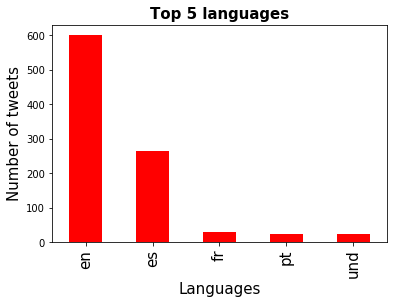

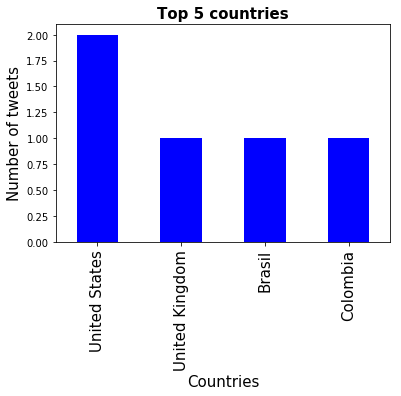

In [31]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

# Hashtag histogram. 

## Please write code that will help you answer the following questions
 1) What is the most used hashtag?
 
 2) What is the most used referenced username?
 
 3) What is the most retweeted tweet?